In [1]:
!pip install gym

In [2]:
!pip install swig

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.0 MB/s eta 0:00:00


In [3]:
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 47.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376172 sha256=fa0b141110848a57575c23514d4de9f2a38e3aca3ed5a46c98f44b5622769077
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [61]:
from math import nan
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
from PIL import Image

class Confounder(nn.Module):
    def __init__(self, in_size, out_size):
        super(Confounder, self).__init__()
        self.fc1 = nn.Linear(in_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, out_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the DQN network
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the DQN agent
class DQNAgent():
    def __init__(self, state_size, action_size, max_memory_size=10000, is_causal = True, batch_size = 256):
        self.state_size = state_size
        self.action_size = action_size
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.q_network = DQN(state_size, action_size).to(dtype=torch.float32,device=self.device)
        self.target_network = DQN(state_size, action_size).to(dtype=torch.float32,device=self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.0005)
        self.memory = deque(maxlen=max_memory_size)
        self.max_memory_size = max_memory_size
        self.batch_size = batch_size
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.95
        self.epsilon_min = 0.001
        self.causal_effects = []
        self.losses = []
        self.is_causal = is_causal
        print(f"CUDA available : {torch.cuda.is_available()}")

    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size) ,\
                 torch.tensor([0.5,0.5],device=self.device)#q values for random state are equally likely

        state = torch.tensor(state, dtype=torch.float32, device=self.device)
        q_values = self.q_network(state)
        return torch.argmax(q_values).item() , q_values

    def remember(self, state, action, reward, next_state, done, q_values):
        self.memory.append((state, action, reward, next_state, done, q_values))

    def replay_opt(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)

        act_r = torch.tensor([experience[1:3] for experience in minibatch], device=self.device)
        actions = act_r[:, 0]
        rewards = act_r[:, 1]
        rewards = rewards.to(torch.float32)
        actions = actions.to(torch.float32)

        P_act = torch.bincount(actions, minlength=self.action_size).float() / self.batch_size
        P_r_act = torch.bincount(actions, weights=rewards, minlength=self.action_size).float() / self.batch_size

        P_act_next = torch.roll(P_act, shifts=-1)
        P_r_act_next = torch.roll(P_r_act, shifts=-1)

        total_effect = torch.sum(torch.abs(P_r_act - P_r_act_next) * P_act * P_act_next)

        if self.is_causal:
            print(f"Causal Effect (b -> d): total_effect == {total_effect}")

        if len(self.causal_effects) > 0:
            self.causal_effects.append(self.causal_effects[-1] + total_effect.cpu().detach())
        else:
            self.causal_effects.append(total_effect.cpu().detach())

        states = torch.tensor([experience[0] for experience in minibatch], dtype=torch.float32, device=self.device)
        next_states = torch.tensor([experience[3] for experience in minibatch], dtype=torch.float32, device=self.device)

        targets = self.q_network(states)

        dones = torch.tensor([experience[4] for experience in minibatch], dtype=targets.dtype, device=self.device)

        max_q_values_next = torch.max(self.target_network(next_states), dim=1).values
        targets[range(self.batch_size), actions] = rewards + (1 - dones) * self.gamma * max_q_values_next

        self.optimizer.zero_grad()

        if self.is_causal:
            loss = nn.MSELoss()(self.q_network(states), targets) + 1 / total_effect
        else:
            loss = nn.MSELoss()(self.q_network(states), targets)

        loss.backward()
        self.losses.append(torch.mean(loss).cpu().detach())
        self.optimizer.step()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)

        act_r = torch.tensor([experience[1:3] for experience in minibatch], dtype = torch.float32, device=self.device)
        actions = act_r[:, 0].int()
        rewards = act_r[:, 1]

        total_effect= 0
        for i in range(self.action_size):
            if i == 0: continue
            if rewards.numel() == 0 :
              total_effect = 0.0
              break
            P_act_i = torch.numel(actions[actions == i])/ len(actions)
            r_act_i = torch.mean(rewards[actions == i]) if rewards[actions == i].size()[0] > 0 else 0.0
            P_r_acti = torch.numel(rewards[actions == i]) / rewards.numel()

            P_act_i_0 = torch.numel(actions[actions == i-1])/ len(actions)
            r_act_i_0 = torch.mean(rewards[actions == i-1]) if rewards[actions == i-1].size()[0] > 0 else 0.0
            P_r_act_i_0 = torch.numel(rewards[actions == i-1]) / rewards.numel()

            total_effect += torch.abs(r_act_i * P_r_acti - r_act_i_0  * P_r_act_i_0)  * P_act_i * P_act_i_0
            #total_effect /= self.action_size - 1
            if torch.isnan(total_effect):
              print(f"Causal Effect (b -> d): abs({r_act_i * P_r_acti} - {r_act_i_0 * P_r_act_i_0}) * {P_act_i} * {P_act_i_0} == {total_effect}")
              total_effect = 0


        state_batch = torch.tensor([experience[0] for experience in minibatch], dtype=torch.float32, device=self.device)
        next_state_batch = torch.tensor([experience[3] for experience in minibatch], dtype=torch.float32, device=self.device)
        done_batch = torch.tensor([experience[4] for experience in minibatch], dtype=torch.bool, device=self.device)

        q_eval = self.q_network(state_batch)[range(self.batch_size),actions]
        target_f = self.target_network(next_state_batch)
        target_f[done_batch] = 0.0

        target = rewards + self.gamma * torch.max(target_f, dim=1)[0]
        target = target.to(torch.float32)
        self.optimizer.zero_grad()

        if self.is_causal:
            loss = nn.MSELoss()(q_eval, target) + 1 / total_effect
            print(f"Causal Effect (b -> d): total_effect == {total_effect}")
        else:
            loss = nn.MSELoss()(q_eval, target)

        loss.backward()
        self.optimizer.step()
        self.losses.append(loss.cpu().detach())

        """if len(self.causal_effects) > 0:
            self.causal_effects.append(self.causal_effects[-1] + total_effect.cpu().detach())
        else:
            self.causal_effects.append(total_effect.cpu().detach())"""\

        self.causal_effects.append(total_effect.cpu().detach())

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


    def replay_old(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)

        #Causal effect = |E(r(act=1)-r(act=0))| P(act=0)*P(act=1)

        #q_values0 = torch.tensor([experience[5][0] for experience in agent.memory])
        #q_values1 = torch.tensor([experience[5][1] for experience in agent.memory])
        act_r = torch.tensor([experience[1:3] for experience in minibatch], device=self.device)
        actions= act_r[:,0]
        rewards = act_r[:,1]


        #################BINARY ACTION SPACE########################
        #P_act0 = torch.numel(actions[actions == 0])/ len(actions)
        #P_act1 = torch.numel(actions[actions == 1])/ len(actions)
        #r_act_1 = torch.mean(rewards[actions == 1])
        #P_r_act1 = torch.numel(rewards[actions == 1]) / rewards.numel()

        #r_act_0 = torch.mean(rewards[actions == 0])
        #P_r_act0 = torch.numel(rewards[actions == 0]) / rewards.numel()

        #r_act_2 = torch.mean(rewards[actions == 2])
        #P_r_act2 = torch.numel(rewards[actions == 2]) / rewards.numel()

        #r_act_3 = torch.mean(rewards[actions == 3])
        #P_r_act3 = torch.numel(rewards[actions == 3]) / rewards.numel()

        total_effect= 0
        for i in range(self.action_size):
            if i == 0: continue

            P_act_i = torch.numel(actions[actions == i])/ len(actions)
            r_act_i = torch.mean(rewards[actions == i])
            P_r_acti = torch.numel(rewards[actions == i]) / rewards.numel()

            P_act_i_0 = torch.numel(actions[actions == i-1])/ len(actions)
            r_act_i_0 = torch.mean(rewards[actions == i-1])
            P_r_act_i_0 = torch.numel(rewards[actions == i-1]) / rewards.numel()

            total_effect += torch.abs(r_act_i * P_r_acti - r_act_i_0  * P_r_act_i_0)  * P_act_i * P_act_i_0
            total_effect /= self.action_size - 1


        #total_effect = torch.abs(r_act_1 * P_r_act1 - r_act_0  * P_r_act0)  * P_act0 * P_act1
        if self.is_causal:
            #print(f"Causal Effect (b -> d): abs({r_act_1 * P_r_act1} - {r_act_0 * P_r_act0}) * {P_act0} * {P_act1} == {total_effect}")
            print(f"Causal Effect (b -> d): total_effect == {total_effect}")

        """if len(self.causal_effects) > 0:
            self.causal_effects.append(self.causal_effects[-1] + total_effect)
        else:"""
        self.causal_effects.append(total_effect)

        minibatch_losses = []

        for state, action, reward, next_state, done, _ in minibatch:
            state = torch.tensor(state, dtype=torch.float32,device=self.device)
            next_state = torch.tensor(next_state, dtype=torch.float32 ,device=self.device)
            target = reward
            if not done:
                target = (reward + self.gamma * torch.max(self.target_network(next_state)))
            target_f = self.q_network(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            if self.is_causal:
                loss = nn.MSELoss()(self.q_network(state), target_f) + 1/total_effect
            else:
                loss = nn.MSELoss()(self.q_network(state), target_f)
            loss.backward()

            #minibatch_losses.append(loss.detach())

            self.optimizer.step()
        minibatch_losses = torch.tensor(minibatch_losses,dtype=torch.float32, device=self.device)
        mean_minibatch_loss = torch.mean(minibatch_losses)
        #self.losses.append(mean_minibatch_loss)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def plot_and_save_metrics(self, episode_rewards, average_test_rewards):
        # Create a figure with subplots
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

        # Plot episode rewards
        ax1.plot(episode_rewards, label='Episode Reward', color='blue')
        ax1.set_ylabel('Episode Reward')
        ax1.set_xlabel('Episode')
        ax1.legend()

        # Plot average test rewards
        ax2.plot(average_test_rewards, label='Average Test Reward', color='green')
        ax2.set_ylabel('Average Test Reward')
        ax2.set_xlabel('Episode')
        ax2.legend()

        # Plot causal effects
        ax3.plot(self.causal_effects, label='Causal Effect', color='red')
        ax3.set_ylabel('Total Causal Effect')
        ax3.set_xlabel('minibatch number')
        ax3.legend()

        # Plot loss
        ax4.plot(self.losses, label='Mean minibatch Causal MSE Loss', color='orange')
        ax4.set_ylabel('Causal MSE loss')
        ax4.set_xlabel('minibatch number')
        ax4.legend()

        filename = 'metrics_plot_Cause.png' if self.is_causal else 'metrics_plot.png'
        # Save the figure as an image
        plt.tight_layout()
        plt.savefig(filename)
        plt.show()
        # Close the figure to free up resources
        plt.close()

    def plot_and_save_metrics_smooth_all(self, episode_rewards, average_test_rewards, window_size=10):
        # Create a figure with subplots
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

        # Plot episode rewards
        ax1.plot(episode_rewards, label='Episode Reward', color='blue')
        ax1.set_ylabel('Episode Reward')
        ax1.set_xlabel('Episode')
        ax1.legend()

        # Plot average test rewards
        ax2.plot(average_test_rewards, label='Average Test Reward', color='green')
        ax2.set_ylabel('Average Test Reward')
        ax2.set_xlabel('Episode')
        ax2.legend()

        # Smooth causal effects with moving average
        causal_effects_smoothed = np.convolve(self.causal_effects, np.ones(window_size)/window_size, mode='valid')
        ax3.plot(causal_effects_smoothed, label='Causal Effect (Smoothed)', color='red')
        ax3.set_ylabel('Total Causal Effect')
        ax3.set_xlabel('Minibatch Number')
        ax3.legend()

        # Smooth causal MSE loss with moving average
        causal_mse_loss_smoothed = np.convolve(self.losses, np.ones(window_size)/window_size, mode='valid')
        ax4.plot(causal_mse_loss_smoothed, label='Mean minibatch Causal MSE Loss (Smoothed)', color='orange')
        ax4.set_ylabel('Causal MSE loss')
        ax4.set_xlabel('Minibatch Number')
        ax4.legend()

        filename = 'metrics_plot_Cause.png' if self.is_causal else 'metrics_plot.png'
        # Save the figure as an image
        plt.tight_layout()
        plt.savefig(filename)
        plt.show()
        # Close the figure to free up resources
        plt.close()

    def plot_and_save_metrics_smooth(self, episode_rewards, average_test_rewards, window_size=10):
        # Create a figure with subplots
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

        # Plot episode rewards
        ax1.plot(episode_rewards, label='Episode Reward', color='blue')
        ax1.set_ylabel('Episode Reward')
        ax1.set_xlabel('Episode')
        ax1.legend()

        # Plot average test rewards
        ax2.plot(average_test_rewards, label='Average Test Reward', color='green')
        ax2.set_ylabel('Average Test Reward')
        ax2.set_xlabel('Episode')
        ax2.legend()

        causal_effects_smoothed = np.convolve(self.causal_effects, np.ones(window_size)/window_size, mode='valid')
        ax3.plot(causal_effects_smoothed, label='Causal Effect (Smoothed)', color='red')
        ax3.set_ylabel('Total Causal Effect')
        ax3.set_xlabel('Episode')
        ax3.legend()

        # Smooth causal MSE loss with moving average
        causal_mse_loss_smoothed = np.convolve(self.losses, np.ones(window_size)/window_size, mode='valid')
        ax4.plot(causal_mse_loss_smoothed, label='Mean minibatch Causal MSE Loss (Smoothed)', color='orange')
        ax4.set_ylabel('Causal MSE loss')
        ax4.set_xlabel('Episode')
        ax4.legend()

        filename = 'metrics_plot_Cause.png' if self.is_causal else 'metrics_plot.png'
        # Save the figure as an image
        plt.tight_layout()
        plt.savefig(filename)
        plt.show()
        # Close the figure to free up resources
        plt.close()


#### train agent

In [62]:
# Initialize lists to store metrics
episode_rewards = []
average_test_rewards = []

keep_best = True
bst_count = 0

# Initialize the CartPole environment
env = gym.make('CartPole')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initialize the DQN agent with a specified max_memory_size
agent = DQNAgent(state_size, action_size, max_memory_size=10000, is_causal=True, batch_size=32)


print(f"AGENT is causal : {agent.is_causal}")

# Training loop
num_episodes = 1000
for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        action , q_values = agent.select_action(state)
        next_state, reward, done, truncated, info = env.step(action)
        agent.remember(state, action, reward, next_state, done, q_values)
        state = next_state
        total_reward += reward
    agent.replay()
    if episode % 10 == 0:
        agent.update_target_network()

    episode_rewards.append(total_reward)

    print(f"Episode: {episode + 1}, Total Reward: {total_reward} epsilon: {agent.epsilon}")
    if keep_best:
      if total_reward > 250:
        print("Found optimal policy, TERMINATING TRAINING ......")
        break


import pickle

# Define a filename to save the agent
if agent.is_causal:
    agent_filename = 'cart-tst-causal.pkl'
else:
    agent_filename = 'cart-tst.pkl'

# Save the trained DQN agent to a file using pickle
with open(agent_filename, 'wb') as agent_file:
    pickle.dump(agent, agent_file)

CUDA available : True
AGENT is causal : True
Episode: 1, Total Reward: 11.0 epsilon: 1.0
Causal Effect (b -> d): total_effect == 0.01556396484375
Episode: 2, Total Reward: 37.0 epsilon: 0.95
Causal Effect (b -> d): total_effect == 0.03076171875
Episode: 3, Total Reward: 39.0 epsilon: 0.9025
Causal Effect (b -> d): total_effect == 0.01556396484375
Episode: 4, Total Reward: 14.0 epsilon: 0.8573749999999999
Causal Effect (b -> d): total_effect == 0.03076171875
Episode: 5, Total Reward: 15.0 epsilon: 0.8145062499999999
Causal Effect (b -> d): total_effect == 0.01556396484375
Episode: 6, Total Reward: 10.0 epsilon: 0.7737809374999999
Causal Effect (b -> d): total_effect == 0.03076171875
Episode: 7, Total Reward: 18.0 epsilon: 0.7350918906249998
Causal Effect (b -> d): total_effect == 0.0
Episode: 8, Total Reward: 25.0 epsilon: 0.6983372960937497
Causal Effect (b -> d): total_effect == 0.01556396484375
Episode: 9, Total Reward: 44.0 epsilon: 0.6634204312890623
Causal Effect (b -> d): total_e

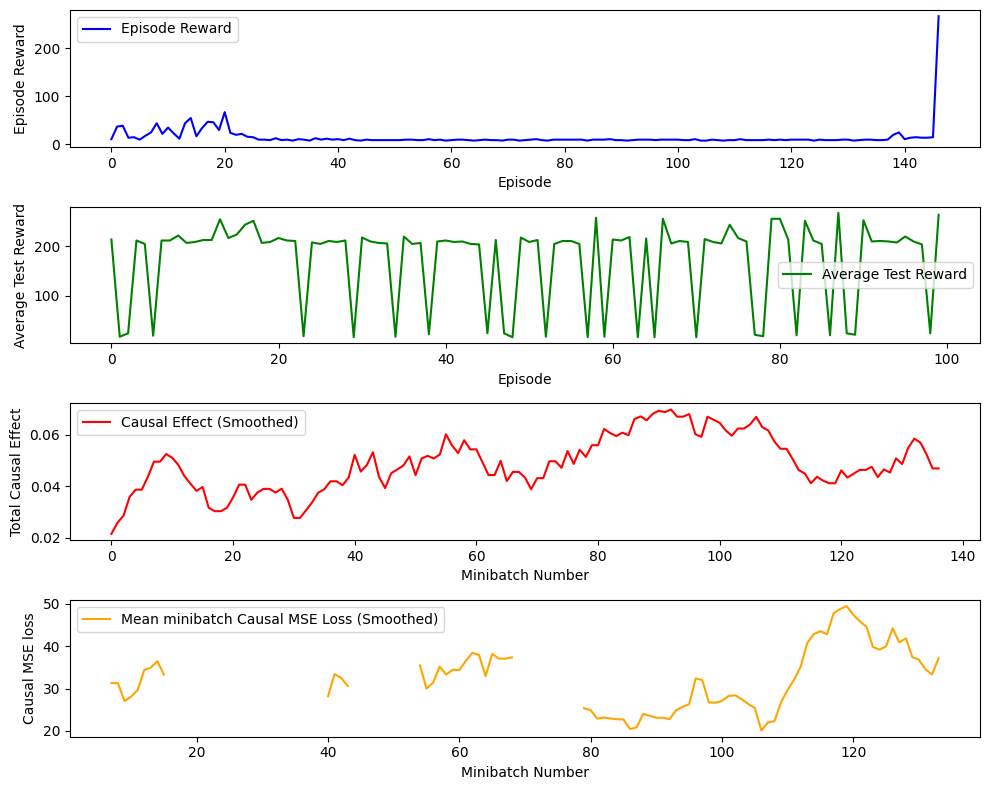

Average Test Reward: 172.18


In [63]:
import pickle

# Define a filename to save the agent
agent_filename = 'cart-tst-causal.pkl'
# Load the trained DQN agent from the saved file
with open(agent_filename, 'rb') as agent_file:
    loaded_agent = pickle.load(agent_file)

# Test the trained agent
test_episodes = 100
test_rewards = []
env = gym.make('CartPole')

# You can now use loaded_agent for inference
# Inference loop using the loaded agent
for _ in range(test_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    while not done:
        # Add a small amount of noise to the state
        noise = np.random.normal(0, scale=0.0, size=state_size)
        state_with_noise = state + noise

        # Select action using the loaded agent with the noisy state
        action, _ = loaded_agent.select_action(state_with_noise)

        state, reward, done, truncated, info = env.step(action)
        total_reward += reward

    test_rewards.append(total_reward)


#agent.plot_and_save_metrics(episode_rewards,test_rewards)
agent.plot_and_save_metrics_smooth_all(episode_rewards,test_rewards)
average_test_reward = sum(test_rewards) / test_episodes
print(f"Average Test Reward: {average_test_reward}")



#### Non-CAUSAL Agent

In [64]:
# Initialize lists to store metrics
episode_rewards = []
average_test_rewards = []

keep_best = True
bst_count = 0

# Initialize the CartPole environment
env = gym.make('CartPole')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initialize the DQN agent with a specified max_memory_size
agent = DQNAgent(state_size, action_size, max_memory_size=10000, is_causal=False, batch_size=64)


print(f"AGENT is causal : {agent.is_causal}")

# Training loop
num_episodes = 1000
for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        action , q_values = agent.select_action(state)
        next_state, reward, done, truncated, info = env.step(action)
        agent.remember(state, action, reward, next_state, done, q_values)
        state = next_state
        total_reward += reward
    agent.replay()
    if episode % 10 == 0:
        agent.update_target_network()

    episode_rewards.append(total_reward)

    print(f"Episode: {episode + 1}, Total Reward: {total_reward} epsilon: {agent.epsilon}")
    if keep_best:
      if total_reward > 200:
        print("Found optimal policy, TERMINATING TRAINING ......")
        break


import pickle

# Define a filename to save the agent
if agent.is_causal:
    agent_filename = 'cart-tst-causal.pkl'
else:
    agent_filename = 'cart-tst.pkl'

# Save the trained DQN agent to a file using pickle
with open(agent_filename, 'wb') as agent_file:
    pickle.dump(agent, agent_file)

CUDA available : True
AGENT is causal : False
Episode: 1, Total Reward: 10.0 epsilon: 1.0
Episode: 2, Total Reward: 35.0 epsilon: 1.0
Episode: 3, Total Reward: 28.0 epsilon: 0.95
Episode: 4, Total Reward: 21.0 epsilon: 0.9025
Episode: 5, Total Reward: 21.0 epsilon: 0.8573749999999999
Episode: 6, Total Reward: 14.0 epsilon: 0.8145062499999999
Episode: 7, Total Reward: 19.0 epsilon: 0.7737809374999999
Episode: 8, Total Reward: 20.0 epsilon: 0.7350918906249998
Episode: 9, Total Reward: 13.0 epsilon: 0.6983372960937497
Episode: 10, Total Reward: 12.0 epsilon: 0.6634204312890623
Episode: 11, Total Reward: 26.0 epsilon: 0.6302494097246091
Episode: 12, Total Reward: 19.0 epsilon: 0.5987369392383786
Episode: 13, Total Reward: 20.0 epsilon: 0.5688000922764596
Episode: 14, Total Reward: 13.0 epsilon: 0.5403600876626365
Episode: 15, Total Reward: 14.0 epsilon: 0.5133420832795047
Episode: 16, Total Reward: 21.0 epsilon: 0.48767497911552943
Episode: 17, Total Reward: 22.0 epsilon: 0.463291230159752

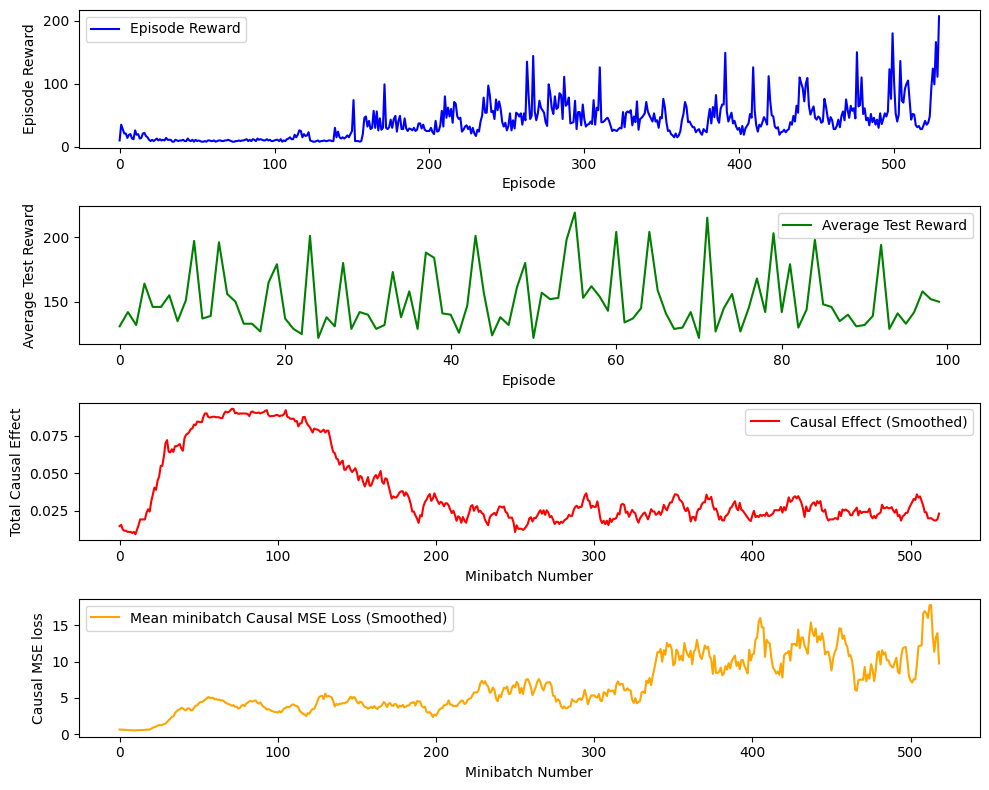

Average Test Reward: 151.17


In [65]:
import pickle

# Define a filename to save the agent
agent_filename = 'cart-tst.pkl'
# Load the trained DQN agent from the saved file
with open(agent_filename, 'rb') as agent_file:
    loaded_agent = pickle.load(agent_file)

# Test the trained agent
test_episodes = 100
test_rewards = []
env = gym.make('CartPole')

# You can now use loaded_agent for inference
# Inference loop using the loaded agent
for _ in range(test_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    while not done:
        # Add a small amount of noise to the state
        noise = np.random.normal(0, scale=0.0, size=state_size)
        state_with_noise = state + noise

        # Select action using the loaded agent with the noisy state
        action, _ = loaded_agent.select_action(state_with_noise)

        state, reward, done, truncated, info = env.step(action)
        total_reward += reward
    test_rewards.append(total_reward)


agent.plot_and_save_metrics_smooth_all(episode_rewards,test_rewards)
average_test_reward = sum(test_rewards) / test_episodes
print(f"Average Test Reward: {average_test_reward}")

#### Agent Battle

episode 0 smith got average : 98.0
episode 1 smith got average : 85.0
episode 2 smith got average : 88.0
episode 3 smith got average : 123.0
episode 4 smith got average : 134.0
episode 0 causal smith got average : 83.0
episode 1 causal smith got average : 659.0
episode 2 causal smith got average : 273.0
episode 3 causal smith got average : 85.0
episode 4 causal smith got average : 73.0
episode 0 smith got average : 431.0
episode 1 smith got average : 111.0
episode 2 smith got average : 78.0
episode 3 smith got average : 103.0
episode 4 smith got average : 116.0
episode 0 causal smith got average : 124.0
episode 1 causal smith got average : 81.0
episode 2 causal smith got average : 173.0
episode 3 causal smith got average : 271.0
episode 4 causal smith got average : 316.0
episode 0 smith got average : 187.0
episode 1 smith got average : 136.0
episode 2 smith got average : 80.0
episode 3 smith got average : 191.0
episode 4 smith got average : 131.0
episode 0 causal smith got average : 26

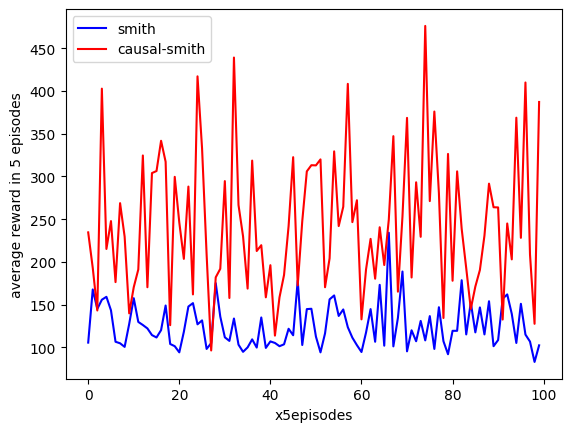

In [43]:
import pickle

seed = 111
env0 = gym.make('CartPole')
env1 = gym.make('CartPole')

env0.reset(seed = seed)
env1.reset(seed = seed)

# Define a filename to save the agent
agent_filename = 'cart-tst.pkl'
# Load the trained DQN agent from the saved file
with open(agent_filename, 'rb') as agent_file:
    agent_smith = pickle.load(agent_file)
import pickle

# Define a filename to save the agent
agent_filename = 'cart-tst-causal.pkl'
# Load the trained DQN agent from the saved file
with open(agent_filename, 'rb') as agent_file:
    causal_agent_smith = pickle.load(agent_file)

war_duration = 100
test_episodes = 5
averages = {'smith':[] , 'causal-smith':[]}

for battle in range(war_duration):
    test_rewards = []
    noise_scl = 0.000 * battle
    for i in range(test_episodes):
        state, _ = env0.reset()
        total_reward = 0
        done = False
        while not done:
            # Add a small amount of noise to the state
            noise = np.random.normal(0, scale=noise_scl, size=state_size)
            state_with_noise = state + noise

            # Select action using the loaded agent with the noisy state
            action, _ = agent_smith.select_action(state_with_noise)

            state, reward, done, truncated, info = env0.step(action)
            total_reward += reward
        test_rewards.append(total_reward)
        print(f"episode {i} smith got average : {total_reward}")

    average_test_reward = sum(test_rewards) / test_episodes
    averages['smith'].append(average_test_reward)

    test_rewards = []
    for i in range(test_episodes):
        state, _ = env1.reset()
        total_reward = 0
        done = False
        while not done:
            # Add a small amount of noise to the state
            noise = np.random.normal(0, scale=noise_scl, size=state_size)
            state_with_noise = state + noise

            # Select action using the loaded agent with the noisy state
            action, _ = causal_agent_smith.select_action(state_with_noise)

            state, reward, done, truncated, info = env1.step(action)
            total_reward += reward
        test_rewards.append(total_reward)
        print(f"episode {i} causal smith got average : {total_reward}")

    average_test_reward = sum(test_rewards) / test_episodes
    averages['causal-smith'].append(average_test_reward)



import matplotlib.pyplot as plt

# Data from the averages dictionary
smith_data = averages['smith']
causal_smith_data = averages['causal-smith']

# Create x-axis values (indexes)
x_values = range(len(smith_data))

# Plot the data
plt.plot(x_values, smith_data, label='smith', color='blue')
plt.plot(x_values, causal_smith_data, label='causal-smith', color='red')

# Add labels and legend
plt.xlabel(f'x{test_episodes}episodes')
plt.ylabel(f'average reward in {test_episodes} episodes')
plt.legend()

# Show the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import gymnasium as gym

# Define seed and environments
seed = 111
env0 = gym.make('CartPole')
env1 = gym.make('CartPole')
env0.reset(seed=seed)
env1.reset(seed=seed)

# Load agents from pickle files
with open('cart-tst.pkl', 'rb') as agent_file:
    agent_smith = pickle.load(agent_file)

with open('cart-tst-causal.pkl', 'rb') as agent_file:
    causal_agent_smith = pickle.load(agent_file)

# Parameters
war_duration = 100
test_episodes = 5
averages = {'smith': [], 'causal-smith': []}
state_size = 4  # Assuming state size for CartPole

# Loop for war duration
for battle in range(war_duration):
    test_rewards = []
    noise_scl = 0.000 * battle
    for i in range(test_episodes):
        state, _ = env0.reset()
        total_reward = 0
        done = False
        while not done:
            noise = np.random.normal(0, scale=noise_scl, size=state_size)
            state_with_noise = state + noise
            action, _ = agent_smith.select_action(state_with_noise)
            state, reward, done, _, _ = env0.step(action)
            total_reward += reward
        test_rewards.append(total_reward)

    average_test_reward = sum(test_rewards) / test_episodes
    averages['smith'].append(average_test_reward)

    test_rewards = []
    for i in range(test_episodes):
        state, _ = env1.reset()
        total_reward = 0
        done = False
        while not done:
            noise = np.random.normal(0, scale=noise_scl, size=state_size)
            state_with_noise = state + noise
            action, _ = causal_agent_smith.select_action(state_with_noise)
            state, reward, done, _, _ = env1.step(action)
            total_reward += reward
        test_rewards.append(total_reward)

    average_test_reward = sum(test_rewards) / test_episodes
    averages['causal-smith'].append(average_test_reward)

# Calculate moving averages
window_size = 10
for key in averages:
    averages[key] = np.convolve(averages[key], np.ones(window_size) / window_size, mode='valid')

# Create x-axis values (indexes)
x_values = range(len(averages['smith']))

# Plot the data
plt.plot(x_values, averages['smith'], label='smith', color='blue')
plt.plot(x_values, averages['causal-smith'], label='causal-smith', color='red')
plt.ylim(bottom = -20,top = 400)
# Set the y-axis bottom limit to 0
plt.gca().set_ylim(bottom=0)

# Add labels and legend
plt.xlabel(f'x{test_episodes}episodes')
plt.ylabel(f'average reward in {test_episodes} episodes')
plt.legend()

# Show the plot
plt.show()
